## Objective

- To do Exploratory Data Analysis (EDA) on Twitter Dataset to make topic modeling and sentimental analysis

#  Data analysis steps to achieve the objective
## 1. Data Understanding
- First read the data and convert it to pandas DataFrame. 
- Generate a report regarding the number of shape of the data(rowXcolumn) 
- Generate a report regarding types of the data in each column
- Identify the missing and NA values in each column.
- identify the target value that is to be predicted


## 2. Data preparation 

- Data type casting should be performed first
- Handling the missing/NA value using various techniques(replacement, etc)
- Encoding categorical values (labelencoder, onehotencoder, etc)
- Normalizing/standardizing the numerical value
- Use correlations to determining the linear relationships between feature variables(heatmap, correlation matrix, pairplots)
- Learn the distribution of data points to identify the outliers, and how do they affect overall distribution. Ex. tools: box plot for 5 number/statistics summary (min, max, med, 1st quartile/25th percentile/Q1, 3rd quartile/75th percentile/Q3), histograms, bar charts
- Dimensionality reduction and feature engineering fo minimize the dimensionalit curse effect


## 3. Modeling 

- Select modeling technique - since the task is a classification, classification model should be selected
- Split the dataset into train and test set
- Build Model the model using the train set

## 4. Metrics

- since the task is classification, we have to use a evaluation metrics that are designed for classificagtion task (accuracy, precision, f1 score)

## 5. How success

- Do the models solve the business problem and what the metrics are telling

# Expected Challenges

- Computational resource constraint
- Slow response from the stakeholders





## 1. Importing the necessary python packages 

In [2]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import os
import re
import sys

sys.path.append(os.path.abspath(os.path.join("./..")))

# custom modules from Day-1
from extract_dataframe import read_json, TweetDfExtractor
from clean_tweets_dataframe import Clean_Tweets
from preprocess_tweet_data import DataPreparation

## 2. Data acquisition
- From the json file given on Day 1 we can extract tweet_data using the extract_dataframe
 1. First tweet_list is generated from the json using read_json function
 2. From the list tweet_data DataFrame is created

In [3]:
_, tweet_list = read_json("../data/global_twitter_data.json")
tweet = TweetDfExtractor(tweet_list)
tweet_data = tweet.get_tweet_df(save=False)
tweet_data.head(50)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Sun Aug 07 22:31:20 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,0.190625,en,0,2,i_ameztoy,20497,2621,None,[City],[i_ameztoy],
1,Sun Aug 07 22:31:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,0.100000,en,0,201,ZIisq,65,272,None,"[China, Taiwan]",[IndoPac_Info],
2,Sun Aug 07 22:31:07 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000e+00,0.000000,en,0,0,Fin21Free,85,392,None,[XiJinping],[ZelenskyyUa],Netherlands
3,Sun Aug 07 22:31:06 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,0.350000,en,0,0,Fin21Free,85,392,None,[XiJinping],,Netherlands
4,Sun Aug 07 22:31:04 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,0.556250,en,0,381,VizziniDolores,910,2608,None,,[ChinaUncensored],"Ayent, Schweiz"
5,Sun Aug 07 22:31:02 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @benedictrogers: We must not let this happe...,2.000000e-01,0.500000,en,0,36,GraceCh15554845,207,54,False,[Taiwan],[benedictrogers],"Melbourne, Victoria"
6,Sun Aug 07 22:30:59 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @TGTM_Official: What kind of country can co...,1.583333e-01,0.800000,en,0,411,Philipkuma1,12,264,None,"[Taiwan, TsaiIngwen]",[TGTM_Official],
7,Sun Aug 07 22:30:59 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @ChinaInfo777: #PinkFloyd singer Roger Wate...,0.000000e+00,0.000000,en,0,5,nhohn2011,870,508,None,"[PinkFloyd, Taiwan, China]",[ChinaInfo777],"Florida, USA"
8,Sun Aug 07 22:30:50 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @AmbQinGang: China's SC&amp;FM Wang Yi elab...,0.000000e+00,0.000000,en,0,239,ClaudioColomaRI,127,263,None,[Taiwan],[AmbQinGang],El mundo periférico
9,Sun Aug 07 22:30:45 +0000 2022,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @CGMeifangZhang: Chinese ambassador to the ...,2.000000e-01,0.375000,en,0,25,jmarzola1,213,877,None,"[USA, Pelosi, Taiwan, China]",[CGMeifangZhang],


In [4]:
# print the information regarding each columns in dataframe
tweet_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          22000 non-null  object 
 1   source              22000 non-null  object 
 2   original_text       22000 non-null  object 
 3   polarity            22000 non-null  float64
 4   subjectivity        22000 non-null  float64
 5   lang                22000 non-null  object 
 6   favorite_count      22000 non-null  int64  
 7   retweet_count       22000 non-null  int64  
 8   original_author     22000 non-null  object 
 9   followers_count     22000 non-null  int64  
 10  friends_count       22000 non-null  int64  
 11  possibly_sensitive  6191 non-null   object 
 12  hashtags            22000 non-null  object 
 13  user_mentions       22000 non-null  object 
 14  place               22000 non-null  object 
dtypes: float64(2), int64(4), object(9)
memory usage: 2.5+

### missing values
- Identify the columns with missing value
- Draw the missing values count on barchart

In [5]:
missing_values = tweet_data.isnull().sum()
print(f"Missing value(s) count: \n{missing_values}")

Missing value(s) count: 
created_at                0
source                    0
original_text             0
polarity                  0
subjectivity              0
lang                      0
favorite_count            0
retweet_count             0
original_author           0
followers_count           0
friends_count             0
possibly_sensitive    15809
hashtags                  0
user_mentions             0
place                     0
dtype: int64


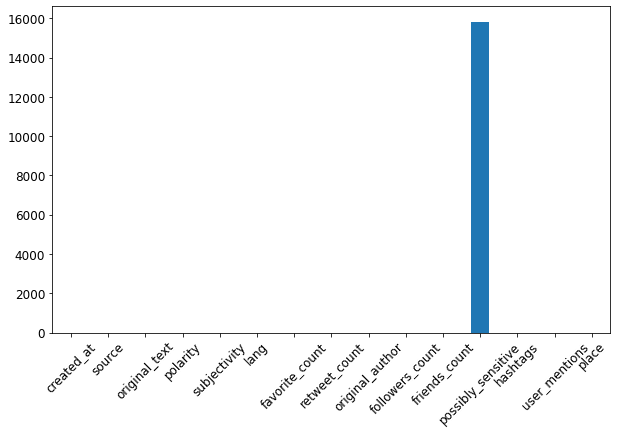

In [6]:
fig = missing_values.plot(kind='bar',fontsize=12, figsize=(10, 6), rot=45).get_figure()
fig.savefig("missing_values_bar_chart.png")

### uni-variate Analysis on Hashtags

In [7]:
#Method to find hashtags from tweets
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)


In [8]:
# update Hashtag column with hashtags extracted from Orignal_text columon
tweet_data['hashtags'] = tweet_data['original_text'].apply(find_hashtags)

# take the rows from the hashtag columns where there are actually hashtags
hashtags_list_df = tweet_data.loc[
                       tweet_data.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]
hashtags_list_df

,hashtags
0,"[#City, #Ta]"
1,"[#China, #Taiwan]"
2,[#XiJinping]
3,[#XiJinping]
5,[#Taiwan]
...,...
21995,"[#China, #Taiwan, #ChinaTaiwanCrisis]"
21996,"[#China, #Taiwan, #ChinaTaiwanCrisis]"
21997,[#Pelosi]
21998,"[#Taiwan, #China]"


In [9]:
#create dataframe where each use of hashtag gets its own row
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in hashtags_list_df.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])

In [10]:
#add flatten_hashtags to tweet_df
tweet_data["flattened_hashtags"]= flattened_hashtags_df
tweet_data.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,flattened_hashtags
0,Sun Aug 07 22:31:20 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,0.190625,en,0,2,i_ameztoy,20497,2621,None,"[#City, #Ta]",[i_ameztoy],,#City
1,Sun Aug 07 22:31:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,0.100000,en,0,201,ZIisq,65,272,None,"[#China, #Taiwan]",[IndoPac_Info],,#Ta
2,Sun Aug 07 22:31:07 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000e+00,0.000000,en,0,0,Fin21Free,85,392,None,[#XiJinping],[ZelenskyyUa],Netherlands,#China
3,Sun Aug 07 22:31:06 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,0.350000,en,0,0,Fin21Free,85,392,None,[#XiJinping],,Netherlands,#Taiwan
4,Sun Aug 07 22:31:04 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,0.556250,en,0,381,VizziniDolores,910,2608,None,[],[ChinaUncensored],"Ayent, Schweiz",#XiJinping


<AxesSubplot:>

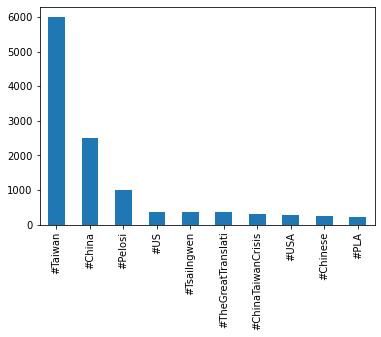

In [11]:
# To plot Top 20 Hashtags
tweet_data['flattened_hashtags'].value_counts()[:10].plot(kind='bar')


### Analyzing the user mentions mentions

In [12]:
#Method to find hashtags from tweets
def find_hashtags(tweet):
    return re.findall('(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

In [13]:
# update Hashtag column with hashtags extracted from Orignal_text columon
tweet_data['user_mentions'] = tweet_data['original_text'].apply(find_hashtags)

# take the rows from the hashtag columns where there are actually hashtags
user_mentions_list_df = tweet_data.loc[
                       tweet_data.user_mentions.apply(
                           lambda user_mentions_list_df: user_mentions_list_df !=[]
                       ),['user_mentions']]
user_mentions_list_df

,user_mentions
0,[@i_ameztoy]
1,[@IndoPac_Info]
2,[@ZelenskyyUa]
4,[@ChinaUncensored]
5,[@benedictrogers]
...,...
21995,[@IndoPac_Info]
21996,[@IndoPac_Info]
21997,[@Reuters]
21998,[@IndoPac_Info]


In [14]:
#create dataframe where each use of hashtag gets its own row
flattened_user_mentions_df = pd.DataFrame(
    [user_mention for user_mentions_list in user_mentions_list_df.user_mentions
    for user_mention in user_mentions_list],
    columns=['user_mentions'])

In [15]:
#add flatten_hashtags to tweet_df
tweet_data["flattened_user_mentions"]= flattened_user_mentions_df
tweet_data.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place,flattened_hashtags,flattened_user_mentions
0,Sun Aug 07 22:31:20 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @i_ameztoy: Extra random image (I):\n\nLets...,-1.250000e-01,0.190625,en,0,2,i_ameztoy,20497,2621,None,"[#City, #Ta]",[@i_ameztoy],,#City,@i_ameztoy
1,Sun Aug 07 22:31:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @IndoPac_Info: #China's media explains the ...,-1.000000e-01,0.100000,en,0,201,ZIisq,65,272,None,"[#China, #Taiwan]",[@IndoPac_Info],,#Ta,@IndoPac_Info
2,Sun Aug 07 22:31:07 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","China even cut off communication, they don't a...",0.000000e+00,0.000000,en,0,0,Fin21Free,85,392,None,[#XiJinping],[@ZelenskyyUa],Netherlands,#China,@ZelenskyyUa
3,Sun Aug 07 22:31:06 +0000 2022,"<a href=""http://twitter.com/download/android"" ...","Putin to #XiJinping : I told you my friend, Ta...",1.000000e-01,0.350000,en,0,0,Fin21Free,85,392,None,[#XiJinping],[],Netherlands,#Taiwan,@ChinaUncensored
4,Sun Aug 07 22:31:04 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...","RT @ChinaUncensored: I’m sorry, I thought Taiw...",-6.938894e-18,0.556250,en,0,381,VizziniDolores,910,2608,None,[],[@ChinaUncensored],"Ayent, Schweiz",#XiJinping,@benedictrogers


## Plot of the Top 10 UserMentions

<AxesSubplot:>

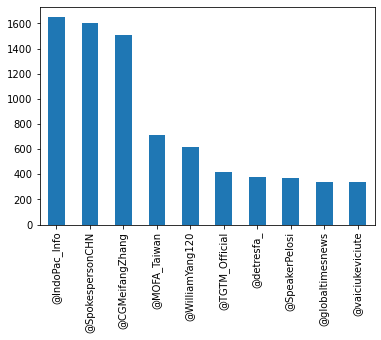

In [16]:
tweet_data['flattened_user_mentions'].value_counts()[:10].plot(kind='bar')


### Text Preprocessing

In [17]:
#text Preprocessing
tweet_data['original_text'] = tweet_data['original_text'].astype(str)
tweet_data['original_text'] = tweet_data['original_text'].apply(lambda x: x.lower())
tweet_data['original_text']= tweet_data['original_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))


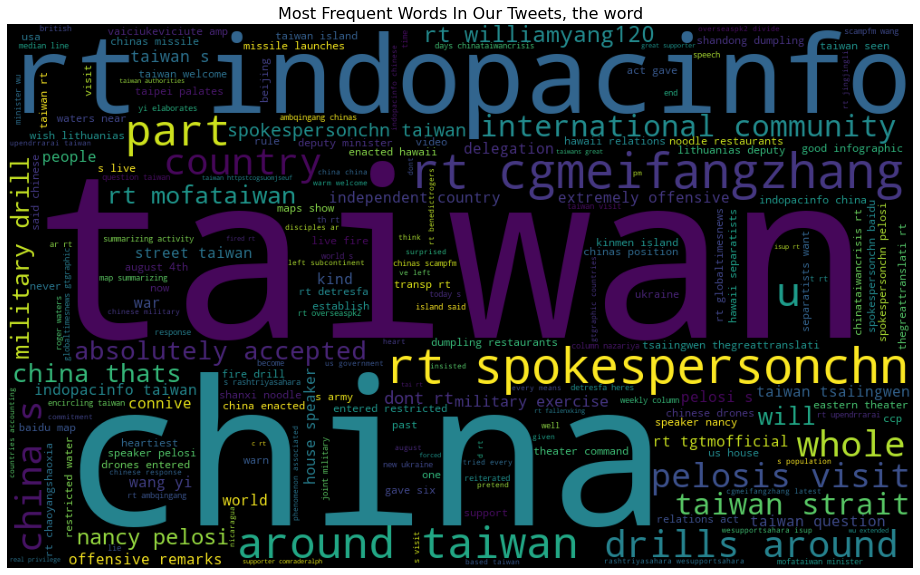

In [18]:
plt.figure(figsize=(20, 10))
plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(tweet_data.original_text .values)))
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets, the word',fontsize=16)
plt.show()

- The word **___taiwan, china, indopacinfo, & spokesperson___** apears are the top 3 words that appear frequently 
- The words **taiwan** and **china** are the most hashtagged words
- The word **indopacinfo** and **spokesperson** are the most mentioned name

## 3. Data preparation
### Data cleaning
- Before further use of the data using the clean_tweets_dataframe python file
 1. Drop unwanted rows 
 2. Convert to datetime - for created_at columns
 3. Convert to numbers for 
  - polarity, subjectivity, retweet_count, favorite_count, followers_count, friends_count
 4. Fill all the none value in possibly_sensitive with False
 5. Drop all the rows with none value
 6. Remove user stopwords, links,special characters, mentions, and hashtag from the tweet text
 7. Expand text such you're to you are
 8. Convert the tweet text lower-case
 9. Finally change the original_text to clean_text - column rename

In [19]:
clean_tweet = Clean_Tweets(tweet_data)
clean_tweet_data = clean_tweet.clean_tweet(tweet_data, save_csv=False)
clean_tweet_data.head()

clean_tweet_data.to_csv('../clean_tweet_dataframe.csv',index=False)

In [20]:
missing_count = clean_tweet_data.isnull().sum()
print(f"Missing value(s) count: \n{missing_count}")

Missing value(s) count: 
created_at                 0
source                     0
clean_text                 0
polarity                   0
subjectivity               0
lang                       0
favorite_count             0
retweet_count              0
original_author            0
followers_count            0
friends_count              0
possibly_sensitive         0
hashtags                   0
user_mentions              0
place                      0
flattened_hashtags         0
flattened_user_mentions    0
dtype: int64


# Users related Analysis

- User related details like:

 1. The total number of users in the dataset
 2. The number of tweets per users
 3. Users with the most liked, shared tweets
 4. The sentiment of the tweets with the most interactions (likes and retweets)


13433 users
Number of posts per user


<AxesSubplot:>

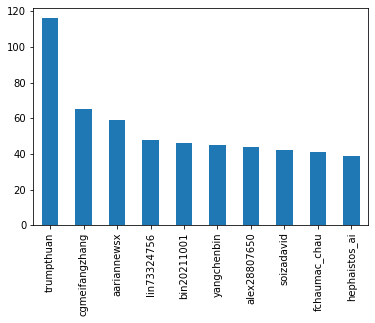

In [21]:
users_count = clean_tweet_data['original_author'].value_counts()
print(len(users_count), "users")
print("Number of posts per user")
users_count[:10].plot(kind='bar')


<AxesSubplot:ylabel='Frequency'>

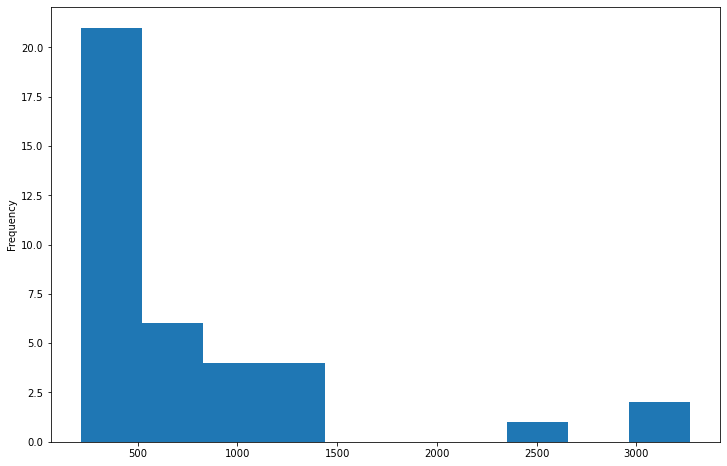

In [22]:
hot_tweets = clean_tweet_data[tweet_data['favorite_count']>200]
hot_tweets['favorite_count'].plot.hist(figsize=(12, 8))

## Identification of soruce of the tweets

we can get the top 3 sources of the twitter data are android, web, and iphone

<AxesSubplot:>

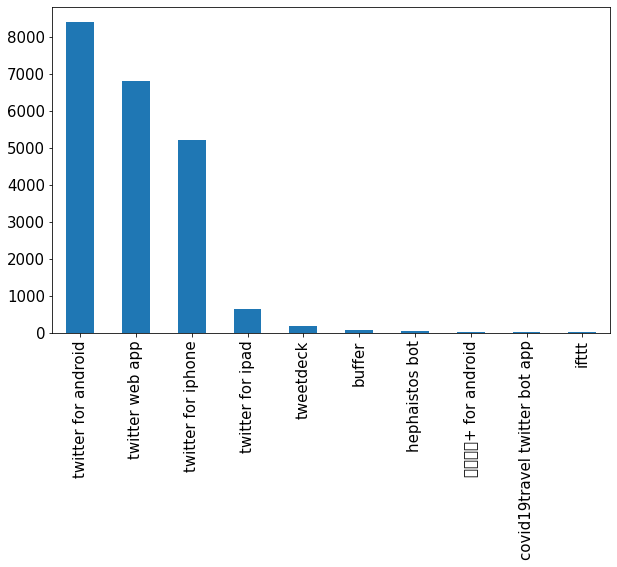

In [23]:
clean_tweet_data['source'].value_counts()[:10].plot(kind='bar', figsize=(10, 6), fontsize=15)

- Most of the tweets coming from android, web app, and iphone are neutral
- the number of positive tweets are less than that of the negative tweets

<AxesSubplot:title={'center':'Common tweet sources polarity'}, xlabel='source,score'>

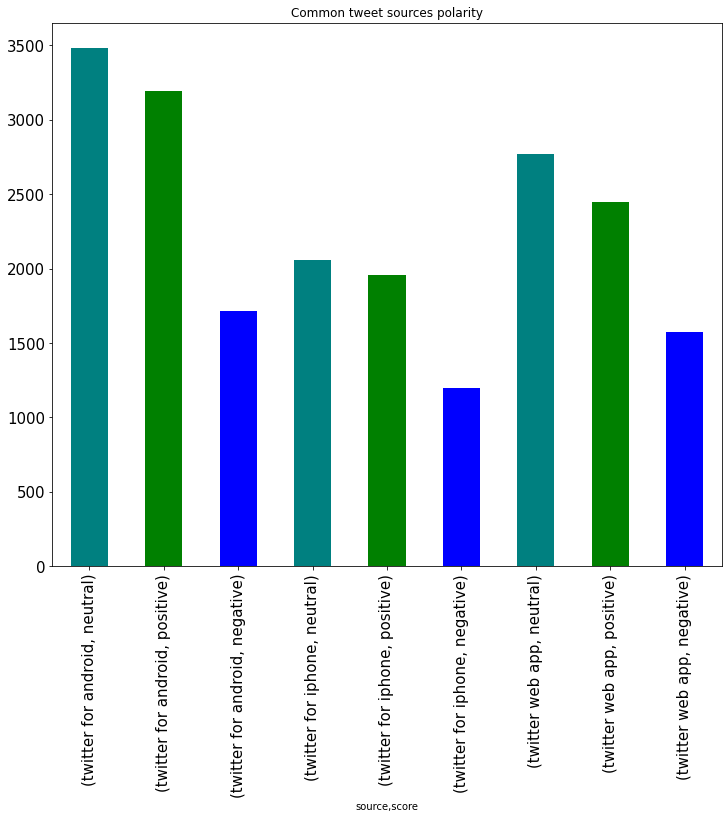

In [27]:
common_source.groupby('source')['score'].value_counts().plot.bar(color=['teal', 'green', 'blue'],
                                                             figsize=(12, 10), 
                                                             fontsize=15,
                                                             title="Common tweet sources polarity")